# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%%time
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
CPU times: user 3.12 s, sys: 3.57 s, total: 6.69 s
Wall time: 7.2 s


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
%%time
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

100%|██████████| 500/500 [00:00<00:00, 4635.00it/s]

loss: 2.368273
sanity check: 2.302585
CPU times: user 135 ms, sys: 21.3 ms, total: 157 ms
Wall time: 179 ms


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
%%time
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 0.308111 analytic: 0.308111, relative error: 2.144129e-07


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 0.248798 analytic: 0.248798, relative error: 2.163774e-07


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 1.839965 analytic: 1.839965, relative error: 1.697761e-08
numerical: -1.465557 analytic: -1.465557, relative error: 6.891691e-09


100%|██████████| 500/500 [00:00<00:00, 5270.26it/s]


numerical: 0.877999 analytic: 0.877999, relative error: 7.942443e-08
numerical: -1.034609 analytic: -1.034609, relative error: 6.287549e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -0.725482 analytic: -0.725482, relative error: 5.525684e-08
numerical: -0.153572 analytic: -0.153572, relative error: 1.101861e-07


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -1.672378 analytic: -1.672378, relative error: 1.502858e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -2.076217 analytic: -2.076218, relative error: 3.482689e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 5.092049 analytic: 5.092049, relative error: 1.386525e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -2.025849 analytic: -2.025850, relative error: 1.683108e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -0.142555 analytic: -0.142555, relative error: 5.818948e-07


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 3.315172 analytic: 3.315172, relative error: 2.455557e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 4.702615 analytic: 4.702614, relative error: 1.293052e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -1.381996 analytic: -1.381996, relative error: 3.189416e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -0.540553 analytic: -0.540553, relative error: 4.381342e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: 0.940002 analytic: 0.940002, relative error: 3.663302e-08


  0%|          | 0/500 [00:00<?, ?it/s]

numerical: -0.794449 analytic: -0.794449, relative error: 8.066714e-08


100%|██████████| 500/500 [00:00<00:00, 4992.11it/s]

numerical: -1.391587 analytic: -1.391587, relative error: 5.221063e-08
CPU times: user 4.3 s, sys: 88 ms, total: 4.39 s
Wall time: 4.4 s


In [6]:
%%time
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

100%|██████████| 500/500 [00:00<00:00, 3009.25it/s]

naive loss: 2.401756e+00 computed in 0.169199s
vectorized loss: 2.401756e+00 computed in 0.013504s
Loss difference: 0.000000
Gradient difference: 0.000000
CPU times: user 147 ms, sys: 11 ms, total: 158 ms
Wall time: 185 ms


In [5]:
%%time
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [0.005, 0.05, 0.5]
regularization_strengths = np.random.rand(10)*(1 - 0.1) + 0.1

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
#pass
from copy import deepcopy
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, reg, num_iters=500)
        acc_train = np.mean(softmax.predict(X_train) == y_train)
        acc_val = np.mean(softmax.predict(X_val) == y_val)
        print('lr:{}, reg:{}, acc_train:{}, val_train:{}'.format(
            lr, reg, acc_train, acc_val))
        results[(lr, reg)] = (acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = deepcopy(softmax)
        
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################   
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))  
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr:0.005, reg:0.375479626021348, acc_train:0.23055102040816328, val_train:0.239
lr:0.005, reg:0.5840316793078945, acc_train:0.2342857142857143, val_train:0.239
lr:0.005, reg:0.8527457439769993, acc_train:0.2663061224489796, val_train:0.271
lr:0.005, reg:0.712540367812775, acc_train:0.23244897959183675, val_train:0.252
lr:0.005, reg:0.4299578793555242, acc_train:0.2563061224489796, val_train:0.254
lr:0.005, reg:0.17547247386468162, acc_train:0.23273469387755102, val_train:0.215
lr:0.005, reg:0.5669463053244274, acc_train:0.24110204081632652, val_train:0.24
lr:0.005, reg:0.14603086825544864, acc_train:0.2843469387755102, val_train:0.287
lr:0.005, reg:0.6237170044383644, acc_train:0.26218367346938776, val_train:0.279
lr:0.005, reg:0.1390030530697803, acc_train:0.3099795918367347, val_train:0.301
lr:0.05, reg:0.375479626021348, acc_train:0.23410204081632652, val_train:0.245
lr:0.05, reg:0.5840316793078945, acc_train:0.17889795918367346, val_train:0.157
lr:0.05, reg:0.8527457439769993, acc_

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.288000


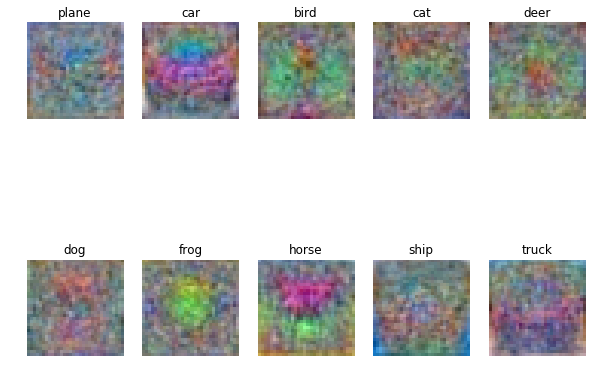

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])